In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:

from fastai.vision import *

In [0]:
bs =64

In [0]:
path=untar_data(URLs.PETS)/'images'

In [5]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/havanese_151.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Birman_160.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/yorkshire_terrier_94.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_98.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_31.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_175.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/beagle_80.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Siamese_34.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/pomeranian_65.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_250.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_186.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Birman_162.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [0]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)


In [0]:
def get_data(size,bs,padding_mode='reflection'):
  return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [0]:
data=get_data(224,bs,'zeros')

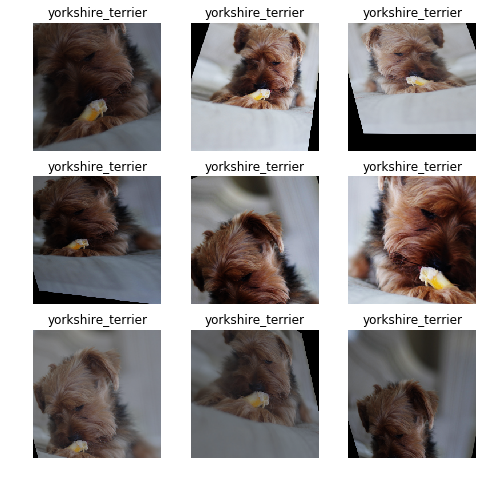

In [10]:
def _plot(i,j,ax):
    x,y = data.train_ds[2]
    x.show(ax, y=y)
    

plot_multi(_plot, 3, 3, figsize=(8,8))

In [0]:
data=get_data(224,bs)

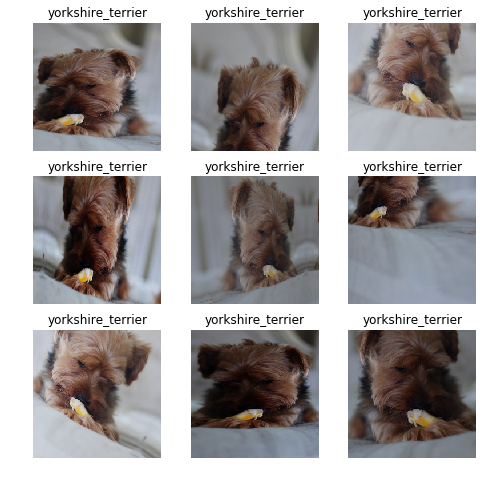

In [12]:
plot_multi(_plot, 3, 3, figsize=(8,8))

In [13]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:05<00:00, 16261471.04it/s]


In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


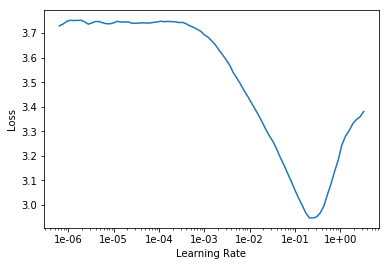

In [15]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(3,slice(8e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.321031,1.118161,0.225304,01:27
1,0.862230,0.341627,0.099459,01:27
2,0.644265,0.246842,0.074425,01:27


In [0]:
learn.unfreeze()

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


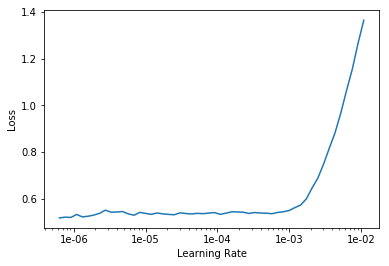

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(2,max_lr=slice(1e-5,5e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.551810,0.256848,0.077808,01:30
1,0.483909,0.230815,0.063599,01:30


In [0]:
learn.data=get_data(352,bs)

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


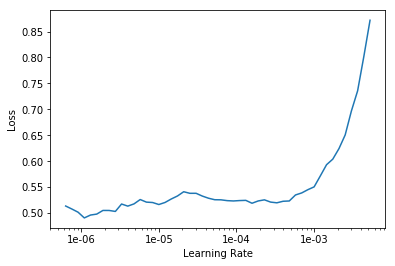

In [23]:
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(2,max_lr=slice(3e-5,8e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.554276,0.332393,0.097429,02:41
1,0.446780,0.201418,0.060893,02:41


In [0]:
learn.save('352')

In [0]:
data=get_data(352,16)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category wheaten_terrier

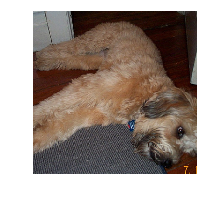

In [29]:
idx=2
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [0]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6

In [31]:
t = data.valid_ds[0][0].data; t.shape

torch.Size([3, 352, 352])

In [0]:
edge = F.conv2d(t[None], k)

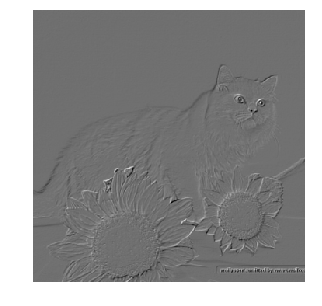

In [33]:
show_image(edge[0], figsize=(5,5));

In [0]:
m=learn.model.eval();

In [56]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[1])
xb = xb.cuda()

IndexError: ignored

In [57]:
Image(data.denorm(xb)[1])

IndexError: ignored

In [0]:
from fastai.callbacks.hooks import *

In [0]:
def hooked_backward(cat=y):
    with hook_output(m[1]) as hook_a: 
        with hook_output(m[1], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [0]:
hook_a,hook_g = hooked_backward()

In [67]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([37])

In [64]:
acts

tensor([ 1.6642,  0.3741,  0.0113, -1.6301, -2.0951, -0.7535, -1.6902,  0.9551,
        -0.9742, -1.6925, -0.2436, -1.1157, -1.5480, -0.8105,  0.5575, -1.5543,
        -0.8121, -0.9954,  1.0734, -0.9272, -2.2111,  3.0031,  0.6435, -1.9764,
        -2.6371,  3.3495, -1.3263,  0.3966,  0.1647, -0.7956,  1.7170, -0.1921,
         2.8541, -0.6864, -2.0415, 10.9815,  0.0685])

In [53]:
avg_acts = acts.mean(0)
avg_acts.shape


torch.Size([11, 11])

In [0]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

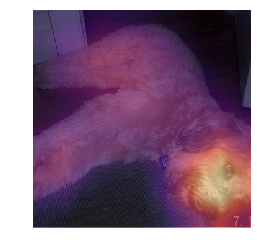

In [65]:
show_heatmap(avg_acts)